In [147]:
import os, sys, json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

from mmengine.config import Config
from opentad.datasets import build_dataset, build_dataloader
from opentad.datasets.base import SlidingWindowDataset, PaddingDataset, filter_same_annotation
from opentad.datasets.pku import PkuSlidingDataset, PkuPaddingDataset

sys.path.append(str(Path.cwd()))
print("lib import completed")

lib import completed


In [182]:
config_path = "configs/adatad/pku_mmd/e2e_pku_mmd_videomae_s_768x1_160_adapter.py"
cfg = Config.fromfile(config_path)

print("config file load")
print(f"path : {config_path}")
print(f"keys : {list(cfg.keys())}")

if hasattr(cfg, "dataset"):
    dataset_cfg = cfg.dataset
    print(f"dataset_cfg keys: {list(dataset_cfg.keys())}")

    if hasattr(dataset_cfg, "train"):
        train_cfg = dataset_cfg.train
        print("train_cfg settings")
        print(f"type : {train_cfg.get('type', 'Unknown')}")
        print(f"ann_file : {train_cfg.get('ann_file', 'Unknown')}")
        print(f"data path : {train_cfg.get('data_prefix', 'Unknown')}")
        print(f"pipelines : {len(train_cfg.get('pipeline', []))}")
else:
    print("dataset_cfg x")


config file load
path : configs/adatad/pku_mmd/e2e_pku_mmd_videomae_s_768x1_160_adapter.py
keys : ['annotation_train', 'annotation_val', 'annotation_test', 'class_map', 'video_dir', 'block_list', 'window_size', 'dataset', 'evaluation', 'model', 'scale_factor', 'chunk_num', 'solver', 'optimizer', 'scheduler', 'inference', 'post_processing', 'workflow', 'work_dir']
dataset_cfg keys: ['train', 'val', 'test']
train_cfg settings
type : PkuPaddingDataset
ann_file : data/PKU-MMD/pku_train.json
data path : Unknown
pipelines : 13


In [188]:
train_dataset = build_dataset(cfg.dataset.train)
val_dataset   = build_dataset(cfg.dataset.val)

# --- dataloaders ---
common = dict(rank=0, world_size=1, num_workers=0)
train_loader = build_dataloader(train_dataset, batch_size=1, shuffle=True,  drop_last=False, **common)
val_loader   = build_dataloader(val_dataset,   batch_size=1, shuffle=False, drop_last=False, **common)

print("✓ datasets & dataloaders built (train/val)")

# --- quick sanity: pull one train batch and show keys/shapes ---
try:
    data_dict = next(iter(train_loader))
    print("✓ train loader works — batch keys:", list(data_dict.keys()))
    if "inputs" in data_dict:
        x = data_dict["inputs"]
        print("  inputs shape:", tuple(x.shape), "dtype:", getattr(x, "dtype", type(x)))
    if "gt_segments" in data_dict:
        segs = data_dict["gt_segments"]
        n_seg = sum(len(s) for s in segs) if isinstance(segs, list) else (segs.numel() // 2 if torch.is_tensor(segs) else 0)
        print("  total gt segments:", n_seg)
    if "gt_labels" in data_dict:
        lbls = data_dict["gt_labels"]
        lbl_tensor = (torch.cat(lbls) if isinstance(lbls, list) and len(lbls) and torch.is_tensor(lbls[0])
                      else (lbls.view(-1) if torch.is_tensor(lbls) else torch.tensor([])))
        if lbl_tensor.numel():
            print("  label id min~max:", int(lbl_tensor.min()), "~", int(lbl_tensor.max()))
except Exception as e:
    import traceback
    print("✗ train loader failed:", e)
    traceback.print_exc()

training subset: 831 videos
validation subset: 111 videos, truncated as 1958 windows.
✓ datasets & dataloaders built (train/val)
✓ train loader works — batch keys: ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']
  inputs shape: (1, 1, 3, 512, 160, 160) dtype: torch.uint8
  total gt segments: 2
  label id min~max: 8 ~ 41


In [189]:
sample = train_dataset[0]
print(f"train dataset sample keys : {list(sample.keys())}")

for key, value in sample.items():
    print(f"{key}")
    print(f"type: {type(value)}")
    if hasattr(value, "shape"):
        print(f"shape: {value.shape}")
        print(f"dtype: {getattr(value, 'dtype', type(value))}")

# 메타 정보 출력
first_sample = train_dataset[10]
print("\nfirst sample metadata:")
for key, value in first_sample.items():
    if key not in ["inputs", "masks", "gt_segments", "gt_labels"]:
        print(f"{key}: {value}")

if "video_name" in first_sample:
    print(f"video name: {first_sample['video_name']}")
if "windows_start_frame" in first_sample:
    print(f"windows start frame: {first_sample['windows_start_frame']}")
if "duration" in first_sample:
    print(f"duration: {first_sample['duration']}")
if "fps" in first_sample:
    print(f"fps: {first_sample['fps']}")
if "snippet_stride" in first_sample:
    print(f"snippet stride: {first_sample['snippet_stride']}")

train dataset sample keys : ['inputs', 'masks', 'gt_segments', 'gt_labels', 'metas']
inputs
type: <class 'torch.Tensor'>
shape: torch.Size([1, 3, 512, 160, 160])
dtype: torch.uint8
masks
type: <class 'torch.Tensor'>
shape: torch.Size([512])
dtype: torch.bool
gt_segments
type: <class 'torch.Tensor'>
shape: torch.Size([3, 2])
dtype: torch.float32
gt_labels
type: <class 'torch.Tensor'>
shape: torch.Size([3])
dtype: torch.int32
metas
type: <class 'dict'>

first sample metadata:
metas: {'video_name': '0006-M', 'data_path': 'F:/dataset/pku-mmd/rgb', 'fps': 30.0, 'duration': 1392, 'snippet_stride': 1, 'window_size': 512, 'offset_frames': 0}


In [190]:
import torch

def inspect_loader(loader, name="loader", max_batches=3):
    print(f"\n{name} 테스트:")
    for b_idx, batch in enumerate(loader):
        if b_idx >= max_batches:
            break
        print(f"  ▸ 배치 {b_idx}")

        if "inputs" in batch:
            inp = batch["inputs"]
            print(f"    inputs shape : {tuple(inp.shape)}  dtype={getattr(inp, 'dtype', type(inp))}")

        if "gt_labels" in batch:
            lbls = batch["gt_labels"]
            if isinstance(lbls, list):
                lbl_tensor = torch.cat(lbls) if len(lbls) and torch.is_tensor(lbls[0]) else torch.tensor([])
            else:
                lbl_tensor = lbls.view(-1)
            if lbl_tensor.numel() > 0:
                print(f"    labels tensor shape : {tuple(lbl_tensor.shape)}")
                print(f"    label id min~max     : {lbl_tensor.min().item()} ~ {lbl_tensor.max().item()}")
            else:
                print("    labels: empty")

        if "gt_segments" in batch:
            segs = batch["gt_segments"]
            n_seg = sum(len(s) for s in segs) if isinstance(segs, list) else (segs.numel() if torch.is_tensor(segs) else 0)
            print(f"    total gt segments    : {n_seg}")

inspect_loader(train_loader, "훈련 DataLoader", max_batches=1)
inspect_loader(val_loader,   "검증 DataLoader", max_batches=1)

print("\n데이터로더 반복 테스트 완료")


훈련 DataLoader 테스트:
  ▸ 배치 0
    inputs shape : (1, 1, 3, 512, 160, 160)  dtype=torch.uint8
    labels tensor shape : (3,)
    label id min~max     : 19 ~ 43
    total gt segments    : 3

검증 DataLoader 테스트:
  ▸ 배치 0
    inputs shape : (1, 1, 3, 512, 160, 160)  dtype=torch.uint8
    labels tensor shape : (3,)
    label id min~max     : 17 ~ 26
    total gt segments    : 3

데이터로더 반복 테스트 완료


got a batch


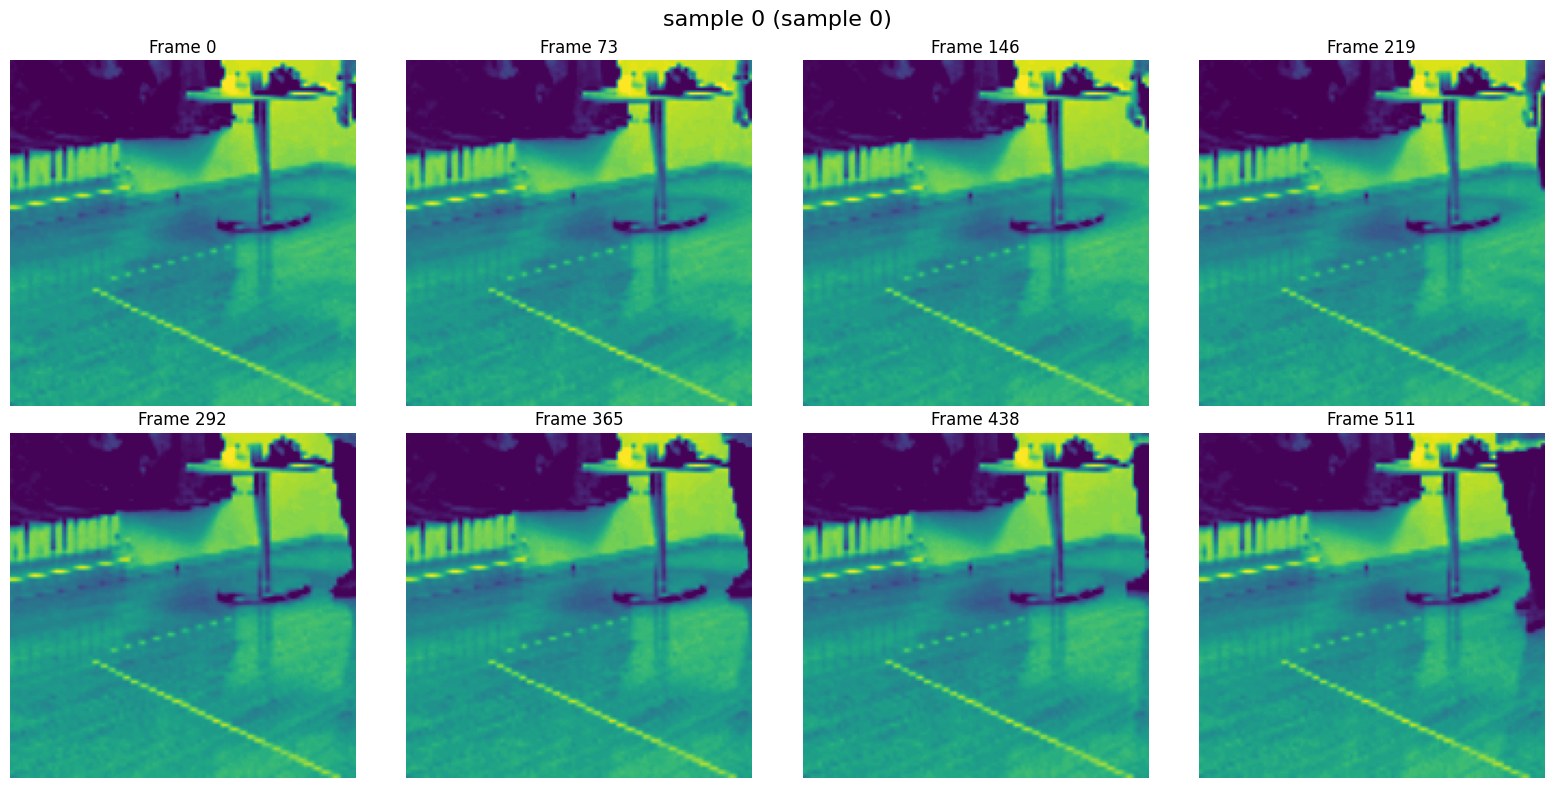


[pku annotation info] sample 0
  #01  label=41  segment=[91.0, 272.0]

[pku metadata] sample 0
  video_name: 0154-L
  data_path: F:/dataset/pku-mmd/rgb
  fps: 30.0
  duration: 3572
  snippet_stride: 1
  window_size: 512
  offset_frames: 0


In [191]:
def visualize_pku_batch_sample(data_dict, sample_idx: int = 0, title: str = "sample"):
    if "inputs" not in data_dict:
        print("no inputs");  return

    inputs = data_dict["inputs"].cpu()
    sample_inputs = inputs[sample_idx]

    # 예상: (C, T, H, W) 또는 (C, N_clip, T, H, W)
    if sample_inputs.dim() == 5:
        sample_inputs = sample_inputs[:, 0]  # 첫 클립만
    elif sample_inputs.dim() != 4:
        raise ValueError(f"Unexpected shape: {sample_inputs.shape}")

    C, T, H, W = sample_inputs.shape
    frame_idx = np.linspace(0, T - 1, 8, dtype=int)

    fig, ax = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f"{title} (sample {sample_idx})", fontsize=16)

    for k, fi in enumerate(frame_idx):
        r, c = divmod(k, 4)
        frame = sample_inputs[:, fi].permute(1, 2, 0).numpy()
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        ax[r, c].imshow((frame * 255).astype("uint8"))
        ax[r, c].set_title(f"Frame {fi}")
        ax[r, c].axis("off")

    plt.tight_layout();  plt.show()

    if {"gt_segments", "gt_labels"} <= data_dict.keys():
        segs, lbls = data_dict["gt_segments"], data_dict["gt_labels"]
        print(f"\n[pku annotation info] sample {sample_idx}")
        if sample_idx < len(segs):
            for i, (seg, lab) in enumerate(zip(segs[sample_idx], lbls[sample_idx])):
                print(f"  #{i+1:02d}  label={int(lab)}  segment={getattr(seg, 'tolist', lambda: seg)()}")
        else:
            print("  no annotation")

    if "metas" in data_dict and sample_idx < len(data_dict["metas"]):
        meta = data_dict["metas"][sample_idx]
        print(f"\n[pku metadata] sample {sample_idx}")
        for k, v in meta.items():
            print(f"  {k}: {v}")

# 첫 배치 가져와 시각화
for batch_idx, data_dict in enumerate(train_loader):
    print("got a batch")
    visualize_pku_batch_sample(data_dict, sample_idx=0, title="sample 0")
    if data_dict["inputs"].shape[0] > 1:
        visualize_pku_batch_sample(data_dict, sample_idx=1, title="sample 1")
    break
